In [29]:
from __future__ import division
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import GPyOpt
from torch.autograd import Variable
from sklearn.linear_model import LogisticRegression

In [4]:
def normalize(data, norm_type):
    if norm_type == "minmax":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].min()) / (data[:,i].max()-data[:,i].min())
        return data
    elif norm_type == "zscore":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].mean()) / (data[:,i].std())
        return data
    elif norm_type == None:
        return data
    else:
        raise ValueError("Please choose a correct normalization type")
#Xnumtrain = torch.tensor(np.vstack([(Xnumtrain[:,i]-Xnumtrain[:,i].min()) / (Xnumtrain[:,i].max()-Xnumtrain[:,i].min()) for i in range(Xnumtrain.size()[1]) if "Tue elsker det her"])).view(-1,2)

def dataprep(data, norm_type = "zscore"):
    for category in categoricals:
        data[category] = data[category].astype("category")

    catdata = []
    for i in range(len(categoricals)):
        catdata.append(data[categoricals[i]].cat.codes.values)
    catdata = torch.tensor(catdata, dtype = torch.int64).T
    
    
    numdata = np.stack([data[col].values for col in numericals], 1)
    numdata = torch.tensor(numdata, dtype=torch.float)

    normalize(numdata, norm_type)
    return catdata, numdata

def permutation(data, cat):
    perm_data = data.copy()
    rand_num = np.random.randint(0 , len(data[cat]) , len(data[cat]))
    perm_data[cat][np.arange(len(data[cat]))] = data[cat][rand_num] 
    df = perm_data
    return df

def reset_data():
    return pd.read_csv("https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv")

def BiasCorrection(points, probs1, probs2, true1, true2, min_threshold = 0.2, max_threshold = 0.8, max_diff = 0.001, show_scatter = True, show_plot = True):
    points = points
    step = 1/points
    thresholds = np.arange(0,1+step,step)

    if show_scatter:
        y_pred1 = (probs1 > 0.5).float()
        y_pred2 = (probs2 > 0.5).float()
        conf1 = confusion_matrix(true1, y_pred1)
        conf2 = confusion_matrix(true2, y_pred2)

        yvals = []
        xvals = []
        yvals.append(conf1[1,1] / (conf1[1,1] + conf1[1,0]))
        xvals.append(conf1[0,1] / (conf1[0,1] + conf1[0,0]))
        yvals.append(conf2[1,1] / (conf2[1,1] + conf2[1,0]))
        xvals.append(conf2[0,1] / (conf2[0,1] + conf2[0,0]))
        plt.scatter(xvals, yvals, c=["blue", "green"])

    tprs1 = []
    fprs1 = []
    tprs2 = []
    fprs2 = []
    for i in range(points+1):
        y_pred1 = (probs1 > thresholds[i]).float()
        y_pred2 = (probs2 > thresholds[i]).float()
        conf1 = confusion_matrix(true1, y_pred1)
        conf2 = confusion_matrix(true2, y_pred2)

        tprs1.append(conf1[1,1] / (conf1[1,1] + conf1[1,0]))
        fprs1.append(conf1[0,1] / (conf1[0,1] + conf1[0,0]))
        tprs2.append(conf2[1,1] / (conf2[1,1] + conf2[1,0]))
        fprs2.append(conf2[0,1] / (conf2[0,1] + conf2[0,0]))

    if show_plot:
        plt.plot(fprs1,tprs1,color="blue")
        plt.plot(fprs2,tprs2,color="green")
        point1 = [0,0]
        point2 = [1,1]
        x_values = [point1[0], point2[0]] 
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values,'--',color="red")
        plt.show()

    # Find the thresholds with the same tpr and fpr
    tprdiff = []
    fprdiff = []
    thresholds1 = []
    thresholds2 = []

    for i in range(len(thresholds)):
        tprval1 = tprs1[i]
        fprval1 = fprs1[i]
        threshold1 = thresholds[i]
        tprindex2 = min(range(len(tprs2)), key=lambda x: abs(tprs2[x]-tprval1))
        threshold2 = thresholds[tprindex2]
        tprval2 = tprs2[tprindex2]
        fprval2 = fprs2[tprindex2]
        tprdiff.append(abs(tprval1 - tprval2))
        fprdiff.append(abs(fprval1 - fprval2))
        thresholds1.append(threshold1)
        thresholds2.append(threshold2)
        #print(tprval1, fprval1, threshold1, tprval2, fprval2, threshold2)

    minthreshold = min_threshold
    maxthreshold = max_threshold
    maxdiff = max_diff
    indeces = np.unique(np.append(np.where(np.array(tprdiff) < maxdiff), np.where(np.array(fprdiff) < maxdiff)))
    thresholds1 = [thresholds1[i] for i in indeces if "Tue elsker det"]
    thresholds2 = [thresholds2[i] for i in indeces if "Tue elsker det"]

    # Find the accuracies for all the thresholds with equal fpr and tpr
    accs = []
    for i in range(len(thresholds1)):
        thres1, thres2 = thresholds1[i], thresholds2[i]
        y_val_white = model(Xcat_white, Xnum_white)
        y_pred1 = (y_val_white > thres1).float()
        y_val_black = model(Xcat_black, Xnum_black)
        y_pred2 = (y_val_black > thres2).float()

        # Ground truth of recidivism from dataset
        y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
        y_black = torch.tensor(black_data["two_year_recid"].values).flatten()
        accs.append((accuracy_score(y_black, y_pred2) + accuracy_score(y_white, y_pred1)) / 2)

    maxaccidx = np.argmax(accs)
    optthres1 = thresholds1[maxaccidx]
    optthres2 = thresholds2[maxaccidx]
    print(optthres1, optthres2, max(accs))

# Data Visualization and Pre-processing

In [5]:
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv"
data = pd.read_csv(url)

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
#print(data.columns)

No GPU available.


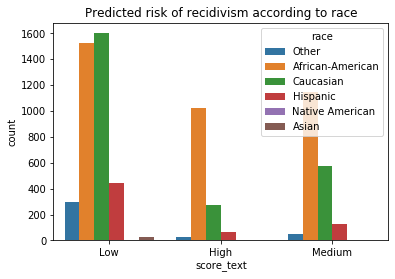

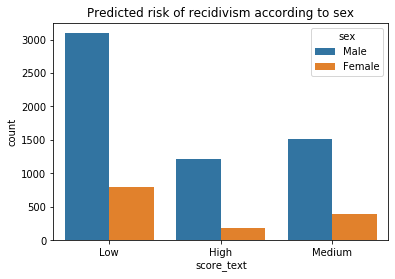

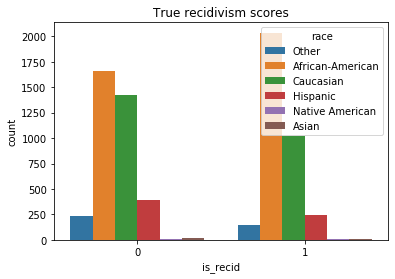

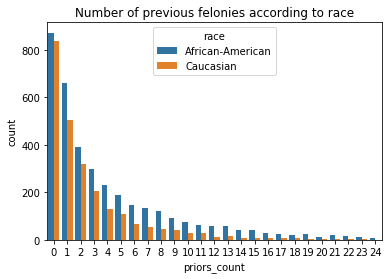

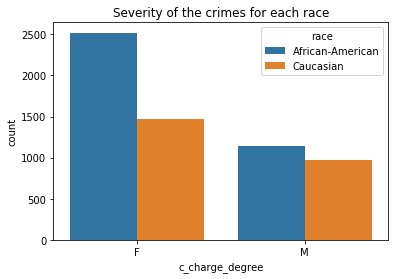

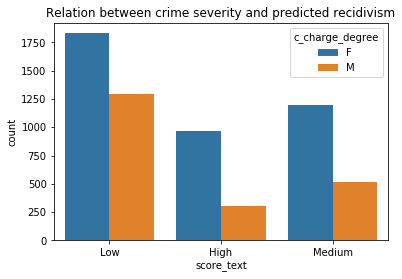

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.47it/s]


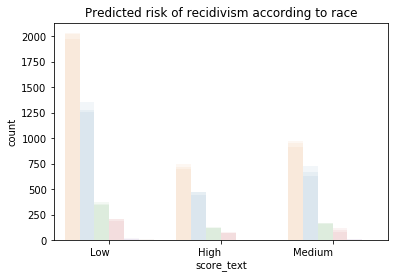

In [6]:
def is_plot():
    
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    
    pred_plot_race = sb.countplot(x = "score_text", hue = "race", data = data)
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    #pred_plot_race.figure.savefig(path + "\\predicted_recid_race.png")
    plt.show()
    
    pred_plot_sex = sb.countplot(x = "score_text", hue = "sex", data = data)
    pred_plot_sex.set_title("Predicted risk of recidivism according to sex")
    #pred_plot_sex.figure.savefig(path + "\\predicted_recid_sex.png")
    plt.show()
    
    true_plot = sb.countplot(x = "is_recid", hue = "race", data = data)
    true_plot.set_title("True recidivism scores")
    #true_plot.figure.savefig(path + "\\true_recid.png")
    plt.show()
    
    df = data[(data["race"] == "African-American") | (data["race"] == "Caucasian")]
    df = df[df["priors_count"] < 25]
    
    priors_plot = sb.countplot(x = "priors_count", hue = "race", data = df)
    priors_plot.set_title("Number of previous felonies according to race")
    #priors_plot.figure.savefig(path + "\\proirs.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "c_charge_degree", hue = "race", data = df)
    c_charge_degree.set_title("Severity of the crimes for each race")
    #c_charge_degree.figure.savefig(path + "\\c_charge_degree.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "score_text", hue = "c_charge_degree", data = df)
    c_charge_degree.set_title("Relation between crime severity and predicted recidivism")
    #c_charge_degree.figure.savefig(path + "\\charge_degree_score.png")
    plt.show()
    
    
is_plot()

palette = {"Caucasian": "C0", "African-American": "C1", "Hispanic": "C2", "Other": "C3" , "Asian": "C4" ,"Native American": "C5"}
for i in tqdm(range(3)):
    #TODO: der skal indsættes punkter for den rigtige data1fordelling. 
    data = permutation(data, "race")
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    pred_plot_race = sb.countplot(x = "score_text" ,hue = "race", data = data, palette = palette ,alpha=.06,  hue_order = [ "African-American","Caucasian", "Hispanic", "Other" , "Asian","Native American"])
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    pred_plot_race.set_xticklabels(pred_plot_race.get_xticklabels(), horizontalalignment ='right')
    pred_plot_race.get_legend().remove()
    data = reset_data()
plt.show()
    


In [7]:
categoricals = ["c_charge_degree", "race", "age_cat", "sex"] # "r_charge_degree"    "two_year_recid"    "is_recid", "is_violent_recid"
numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"] # "days_b_screening_arrest"
outputs = ["score_text"]
data = data[categoricals + numericals + outputs + ["two_year_recid"] + ["is_recid"]]

# Making the output binary
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',1)
data[outputs] = data[outputs].astype("category")

In [8]:
Xcat, Xnum = dataprep(data, norm_type = "zscore")

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = data["is_recid"][totalnumber - testnumber:totalnumber]
ytest = torch.tensor(ytest.values).flatten()


# Make sure that we dont validate on training data to compare if the algorithm is biased


normalize(Xnumtrain, "zscore");
normalize(Xnumtest, "zscore");

# Neural Network

In [9]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return nn.functional.sigmoid(x)

# Train model on data

In [51]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True


Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(6, 3)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64

In [52]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5

In [53]:
# thresholds = np.random.uniform(0,1,size=points)
    
def train_model(hyperparameters, model, epochs = 100, plot = False):
    in_features, out_features = 11, 1
    p = hyperparameters['p']
    hidden_units_1 = hyperparameters['hidden_units_1']
    hidden_units_2 = hyperparameters['hidden_units_2']
    hidden_units_3 = hyperparameters['hidden_units_3']
    hidden_units_4 = hyperparameters['hidden_units_4']
    hidden_units_5 = hyperparameters['hidden_units_5']
    activation_func = hyperparameters['activation_func']
    
    model.layers[0] = torch.nn.Linear(in_features, hidden_units_1) 
    model.layers[1] = activation_func
    model.layers[2] = torch.nn.BatchNorm1d(hidden_units_1)
    model.layers[3] = torch.nn.Dropout(p=p)
    model.layers[4] = torch.nn.Linear(hidden_units_1, hidden_units_2) 
    model.layers[5] = activation_func
    model.layers[6] = torch.nn.BatchNorm1d(hidden_units_2)
    model.layers[7] = torch.nn.Dropout(p=p)
    model.layers[8] = torch.nn.Linear(hidden_units_2, hidden_units_3) 
    model.layers[9] = activation_func
    model.layers[10] = torch.nn.BatchNorm1d(hidden_units_3)
    model.layers[11] = torch.nn.Dropout(p=p)
    model.layers[12] = torch.nn.Linear(hidden_units_3, hidden_units_4) 
    model.layers[13] = activation_func
    model.layers[14] = torch.nn.BatchNorm1d(hidden_units_4)
    model.layers[15] = torch.nn.Dropout(p=p)
    model.layers[16] = torch.nn.Linear(hidden_units_4, hidden_units_5) 
    model.layers[17] = activation_func
    model.layers[18] = torch.nn.BatchNorm1d(hidden_units_5)
    model.layers[19] = torch.nn.Dropout(p=p)
    model.layers[20] = torch.nn.Linear(hidden_units_5, out_features) 
    
    aggregated_losses = []
    
    # Initialize lists for training and validation
    train_iter = []
    train_loss, train_accs = [], []
    valid_iter = []
    valid_loss, valid_accs = [], []

    model.train()
    for i in range(epochs):
        i += 1
        y_pred = model(Xcattrain, Xnumtrain)
        single_loss = loss_function(y_pred, ytrain.float())
        aggregated_losses.append(single_loss)

        #if i % 25 == 1:
            #print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


    
    # Plot the loss over epocs
    if plot:
        plt.plot(range(epochs), aggregated_losses)
        plt.ylabel('Loss')
        plt.xlabel('epoch');


    # Predict on the test set
    model.eval()
    with torch.no_grad():
        y_val = model(Xcattest, Xnumtest)
        loss = loss_function(y_val, ytest.float())


    y_val = (y_val > threshold).float()

    
    #print(confusion_matrix(ytest,y_val))
    #print(classification_report(ytest,y_val))
    neural_acc = accuracy_score(ytest, y_val)
    
    return model, float(neural_acc)

# Baysian Optimization

In [23]:
ACTIV = {0: torch.nn.Tanh(),
         1: torch.nn.ReLU(),
         2: torch.nn.ReLU6(),
         3: torch.nn.Sigmoid(),
        }

netsize = 246

## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    hyperparameters = {
        'hidden_units_1': int(np.ceil(param[0]*netsize*0.4)+int(10)),
        'hidden_units_2': int(np.ceil(param[0]*netsize*0.7)+int(10)),
        'hidden_units_3': int(np.ceil(param[0]*netsize)+int(10)),
        'hidden_units_4': int(np.ceil(param[0]*netsize*0.7)+int(10)),
        'hidden_units_5': int(np.ceil(param[0]*netsize*0.4)+int(10)),
        'p': param[1],
        'activation_func': ACTIV[int(param[2])]
    }
    print(hyperparameters)
    trained_model, neural_acc  = train_model(hyperparameters, model)
    print(neural_acc)
    return -neural_acc
    
# define the dictionary for GPyOpt
domain = [{'hidden_units'   : 'var_1', 'type': 'continuous', 'domain': (0 , 1)},
          {'p'              : 'var_2', 'type': 'continuous',  'domain': (0 , 1)},
          {'activation_func': 'var_3', 'type': 'categorical','domain': tuple(np.arange(4))}]


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 100) 


x_best = opt.X[np.argmin(opt.Y)]
print("bedste: ", x_best)
#print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
#    x_best[2])  + ", criterion=" + str(
#    x_best[3]))

[[0.779691   0.33370861 2.        ]]
{'hidden_units_1': 87, 'hidden_units_2': 145, 'hidden_units_3': 202, 'hidden_units_4': 145, 'hidden_units_5': 87, 'p': 0.33370861113902184, 'activation_func': ReLU6()}


KeyboardInterrupt: 

# Baseline

In [11]:

def baseline(data):
    if len(data[data["score_text"] == 0]) > len(data[data["score_text"] == 1]):
        y_pred = [0] * len(data["score_text"])
        y_pred = torch.tensor(y_pred)
    else:
        y_pred = [1] * len(data["score_text"])
        y_pred = torch.tensor(y_pred)
    return y_pred

trues = torch.tensor(data["score_text"])
y_pred = baseline(data)
conf_baseline = confusion_matrix(y_pred,trues)
print(conf_baseline)
print(conf_baseline / conf_baseline.astype(np.float).sum())
baseline_acc = accuracy_score(y_pred, trues)
print(baseline_acc)
print("Difference between baseline and neural network:", neural_acc - baseline_acc)

[[3897 3317]
 [   0    0]]
[[0.54019961 0.45980039]
 [0.         0.        ]]
0.5401996118658164


NameError: name 'neural_acc' is not defined

# Train the Model

In [10]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True


Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(6, 3)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64

In [11]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5
epochs = 100
np.random.seed(42)

epoch:   1 loss: 0.74495029
epoch:  26 loss: 0.67240638
epoch:  51 loss: 0.63025826
epoch:  76 loss: 0.59908050
epoch: 100 loss: 0.5776149035
[[597 140]
 [344 361]]
[[0.63443146 0.1487779 ]
 [0.68662675 0.72055888]]
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       737
           1       0.72      0.51      0.60       705

    accuracy                           0.66      1442
   macro avg       0.68      0.66      0.66      1442
weighted avg       0.68      0.66      0.66      1442

0.6643550624133149


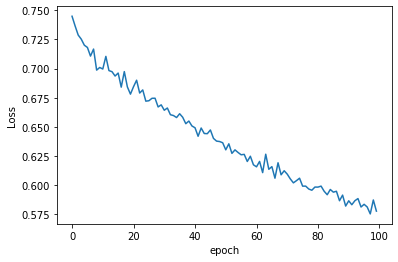

In [12]:
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain.float())
    aggregated_losses.append(single_loss)

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')



# Plot the loss over epocs
if "plot":
    plt.plot(range(epochs), aggregated_losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest.float())


y_pred = (y_val > threshold).float()


conf = confusion_matrix(ytest,y_pred)
conf_norm = np.copy(conf).astype(float)
for i in range(2):
    conf_norm[i,:] = conf[i,:] / np.sum(conf, axis = 0)[i]

print(conf)
print(conf_norm)
print(classification_report(ytest,y_pred))
print(accuracy_score(ytest, y_pred))

# Confusion matrix for black/white

In [13]:
df = data[totalnumber - testnumber:totalnumber]
black_data = df[df["race"]=="African-American"]
white_data = df[df["race"]=="Caucasian"]
Xcat_white, Xnum_white = dataprep(white_data, norm_type = "zscore")
Xcat_black, Xnum_black = dataprep(black_data, norm_type = "zscore")
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_pred1 = (y_val_white > threshold).float()
y_val_black = model(Xcat_black, Xnum_black)
y_pred2 = (y_val_black > threshold).float()

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
y_black = torch.tensor(black_data["two_year_recid"].values).flatten()

print("Confussion matrix for the white:")
conf_white = confusion_matrix( y_white, y_pred1)
conf_black = confusion_matrix( y_black, y_pred2)

conf_white_norm = np.copy(conf_white).astype(float)
conf_black_norm = np.copy(conf_black).astype(float)
for i in range(2):
    conf_white_norm[i,:] = conf_white[i,:] / np.sum(conf_white, axis = 1)[i]
    conf_black_norm[i,:] = conf_black[i,:] / np.sum(conf_black, axis = 1)[i]

print(conf_white)
print(conf_white_norm)
print()
print("Confussion matrix for the black:")
print(conf_black)
print(conf_black_norm)

#print(conf_white / conf_white.astype(np.float).sum(axis=1))
#print(conf_black / conf_black.astype(np.float).sum(axis=1))
#[0.21548821548821548, 0.3638968481375358] [0.5674157303370787, 0.6658227848101266]
#00 / 00 + 10
#01 / 01 + 00

Confussion matrix for the white:
[[244  53]
 [ 89  89]]
[[0.82154882 0.17845118]
 [0.5        0.5       ]]

Confussion matrix for the black:
[[273  76]
 [198 197]]
[[0.78223496 0.21776504]
 [0.50126582 0.49873418]]


* # Fede plots til fremtiden måske:


# Plots of the distribution of black and whites in each category of scoretext
sb.countplot(x = "score_text", data = black_data)
print(len(black_data[black_data["score_text"] == 0]))
print(len(black_data[black_data["score_text"] == 1]))
plt.show()
sb.countplot(x = "score_text", data = white_data)
print(len(white_data[white_data["score_text"] == 0]))
print(len(white_data[white_data["score_text"] == 1]))
plt.show()

# Neural Network Bias Correction

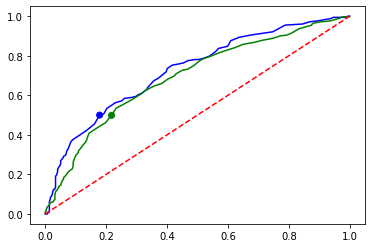

0.48 0.48 0.6713822863610639


In [14]:
BiasCorrection(100, y_val_white, y_val_black, y_white, y_black, show_scatter = True, show_plot = True)

[0.         0.17845118 1.        ] [0.  0.5 1. ]


NameError: name 'x_values' is not defined

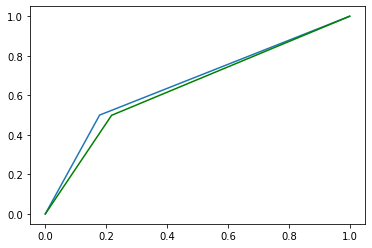

In [15]:
from sklearn import metrics
y_pred1 = (y_val_white > 0.5).float()
y_pred2 = (y_val_black > 0.5).float()
fpr, tpr, thresholds = metrics.roc_curve(y_white, y_pred1.view(-1),pos_label=1)
fpr2, tpr2, thresholds = metrics.roc_curve(y_black, y_pred2.view(-1),pos_label=1)
print(fpr,tpr)
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2,color="green")
plt. plot(x_values, y_values,'--',color="red")
plt.show()

# Random Forest

In [32]:
class RandomForest:
    
    def __init__(self, xtrain, ytrain, n_estimators = 53, max_depth = 14, max_features = "log2", criterion = "entropy"):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.forestModel = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features, criterion = criterion)
        self.forestModel.fit(self.xtrain, self.ytrain)
        
    

    def Validate(self, model, datatest, ytest, show_acc = True):
        # Predict on the test set
        self.forestPreds = model.predict(datatest)
        self.forestProbs = model.predict_proba(datatest)[:, 1]

        if show_acc:
            print("Predicted no recidivism: ", len(self.forestPreds[self.forestPreds == 0]))
            print("Predicted recidivism: ", len(self.forestPreds[self.forestPreds == 1]))

            print("Accuracy of the random forest model: ", len(self.forestPreds[torch.tensor(self.forestPreds, dtype = torch.int64) == ytest]) / len(self.forestPreds))
            self.conf = confusion_matrix(ytest, self.forestPreds)
            self.conf_norm = np.copy(self.conf).astype(float)
            for i in range(2):
                self.conf_norm[i,:] = self.conf[i,:] / np.sum(conf, axis = 1)[i]
            print(self.conf)
            print(self.conf_norm)
            print()

orig_test = RandomForest(Xcattrain, ytrain)
orig_test.Validate(orig_test.forestModel, Xcattest, ytest)


# Test for bias
rf_white_test = RandomForest(Xcattrain, ytrain)
rf_black_test = RandomForest(Xcattrain, ytrain)
rf_white_test.Validate(orig_test.forestModel, Xcat_white, y_white)
rf_black_test.Validate(orig_test.forestModel, Xcat_black, y_black)

Predicted no recidivism:  696
Predicted recidivism:  746
Accuracy of the random forest model:  0.5943134535367545
[[424 313]
 [272 433]]
[[0.57530529 0.42469471]
 [0.3858156  0.6141844 ]]

Predicted no recidivism:  360
Predicted recidivism:  115
Accuracy of the random forest model:  0.64
[[243  54]
 [117  61]]
[[0.32971506 0.07327001]
 [0.16595745 0.08652482]]

Predicted no recidivism:  149
Predicted recidivism:  595
Accuracy of the random forest model:  0.553763440860215
[[ 83 266]
 [ 66 329]]
[[0.11261872 0.36092266]
 [0.09361702 0.46666667]]



# Random Forest Bias Correction

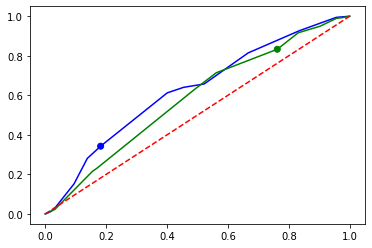

0.8200000000000001 0.75 0.5868902093944539


In [33]:
BiasCorrection(100, torch.tensor(rf_white_test.forestProbs, dtype = torch.float).reshape(-1, 1), torch.tensor(rf_black_test.forestProbs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Logistic Regression

In [34]:
class LogReg:
    
    def __init__(self, xtrain, ytrain):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.regressionModel = LogisticRegression()
        self.regressionModel.fit(self.xtrain, self.ytrain)
        
    varr = 2

    def Validate(self, model, datatest, ytest, show_acc = True):
        # Predict on the test set
        self.regressionPreds = model.predict(datatest)
        self.regressionProbs = model.predict_proba(datatest)[:, 1]

        if show_acc:
            print("Predicted no recidivism: ", len(self.regressionPreds[self.regressionPreds == 0]))
            print("Predicted recidivism: ", len(self.regressionPreds[self.regressionPreds == 1]))

            print("Accuracy of the linear regression model: ", len(self.regressionPreds[torch.tensor(self.regressionPreds, dtype = torch.int64) == ytest]) / len(self.regressionPreds))
            self.conf = confusion_matrix(ytest, self.regressionPreds)
            self.conf_norm = np.copy(self.conf).astype(float)
            for i in range(2):
                self.conf_norm[i,:] = self.conf[i,:] / np.sum(conf, axis = 1)[i]
            print(self.conf)
            print(self.conf_norm)
            print()

logreg_model = LogReg(Xcattrain, ytrain)
logreg_model.Validate(logreg_model.regressionModel, Xcat_white, y_white)

# Test for bias
lr_white_test = LogReg(Xcattrain, ytrain)
lr_black_test = LogReg(Xcattrain, ytrain)
lr_white_test.Validate(logreg_model.regressionModel, Xcat_white, y_white)
lr_black_test.Validate(logreg_model.regressionModel, Xcat_black, y_black)

Predicted no recidivism:  436
Predicted recidivism:  39
Accuracy of the linear regression model:  0.631578947368421
[[279  18]
 [157  21]]
[[0.37856174 0.02442334]
 [0.22269504 0.02978723]]

Predicted no recidivism:  436
Predicted recidivism:  39
Accuracy of the linear regression model:  0.631578947368421
[[279  18]
 [157  21]]
[[0.37856174 0.02442334]
 [0.22269504 0.02978723]]

Predicted no recidivism:  197
Predicted recidivism:  547
Accuracy of the linear regression model:  0.5887096774193549
[[120 229]
 [ 77 318]]
[[0.16282225 0.31071913]
 [0.10921986 0.45106383]]



# Bias Correction for Logistic Regression

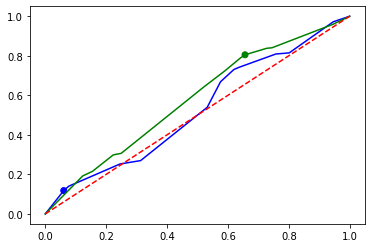

0.54 0.6900000000000001 0.6255701754385965


In [36]:
BiasCorrection(100, torch.tensor(lr_white_test.regressionProbs, dtype = torch.float).reshape(-1, 1), torch.tensor(lr_black_test.regressionProbs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)